# Selection Bias

Relevant articles: 

https://www.aei.org/carpe-diem/2016-sat-test-results-confirm-pattern-thats-persisted-for-45-years-high-school-boys-are-better-at-math-than-girls/

https://www.aei.org/economics/sat-results-dont-confirm-boys-better-at-math-than-girls/

https://www.aei.org/carpe-diem/actually-50-years-of-test-scores-do-confirm-that-boys-outperform-girls-on-the-sat-math-test/

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.random

import pymc as pm
import arviz as az
import xarray as xr
import pytensor.tensor as pt 

from utils import value_counts, decorate

from scipy.special import expit


In [26]:
# Make the figures smaller to save some screen real estate
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]
plt.rcParams["axes.titlelocation"] = "left"

## SAT Data

Data from https://fairnessmeasures.github.io/Pages/DatasetPages/SAT.html

Zehlike, Meike, Carlos Castillo, Francesco Bonchi, Ricardo Baeza-Yates, Sara Hajian, Mohamed Megahed. “Fairness Measures: Datasets and software for detecting algorithmic discrimination.” June, 2017. http://fairness-measures.org/ [bibtex]

Ultimately from:

2011 math: https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Mathemathics_Percentile_Ranks_2011.pdf

2011 writing: https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Writing_Percentile_Ranks_2011.pdf

2012 mathematics: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Mathemathics-Percentile-Ranks-2012.pdf

2011 composite: https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Percentile-Ranks-Composite-CR-M-W-2011.pdf

https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Percentile-Ranks-Composite-CR-M_2011.pdf

2012 reading: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Critical-Reading-Percentile-Ranks-2012.pdf

2012 composite: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-W-2012.pdf

https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-2012.pdf

2013 composite: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-W-2013.pdf

https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-2013.pdf

https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-W-2013.pdf

2013 mathematics: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Mathematics-Percentile-Ranks-2013.pdf

2013 reading: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Critical-Reading-Percentile-Ranks-2013.pdf

2014: https://web.archive.org/web/20160402182221/https://secure-media.collegeboard.org/digitalServices/pdf/sat/sat-percentile-ranks-mathematics-2014.pdf

2015: https://web.archive.org/web/20211222094405/https://secure-media.collegeboard.org/digitalServices/pdf/sat/sat-percentile-ranks-mathematics-2015.pdf

2016: 



In [27]:
def read_sat_math(year):
    df = pd.read_csv(f'sat_math_{year}.csv', index_col=0)
    df.columns = ['Total', 'Male', 'Female']
    return df

In [28]:
df_map = {}
years = range(2011, 2016)
for year in years:
    df_map[year] = read_sat_math(year)

In [29]:
df_map[2011].sum()

Total     1647123
Male       770605
Female     876518
dtype: int64

In [30]:
df_map[2012].sum()

Total     1664479
Male       778142
Female     886337
dtype: int64

In [31]:
df_map[2013].sum()

Total     1660047
Male       776092
Female     883955
dtype: int64

In [32]:
df_map[2014].sum()

Total     1672395
Male       783570
Female     888825
dtype: int64

In [33]:
df_map[2015].sum()

Total     1698521
Male       794802
Female     903719
dtype: int64

In [34]:
from empiricaldist import Pmf

def make_pmf(df, col):
    pmf = Pmf(df[col])
    pmf.normalize()
    return pmf

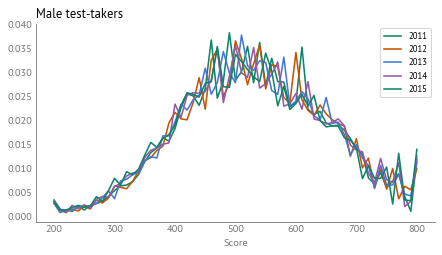

In [35]:
for year, df in df_map.items():
    pmf = make_pmf(df, 'Male')
    pmf.plot(label=year)

decorate(title='Male test-takers')

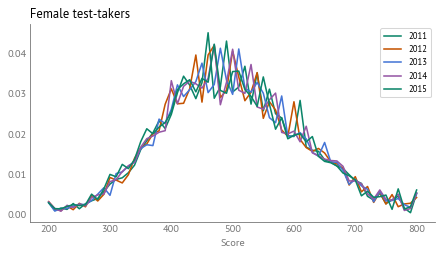

In [36]:
for year, df in df_map.items():
    pmf = make_pmf(df, 'Female')
    pmf.plot(label=year)

decorate(title='Female test-takers')

In [37]:
def compare_spikes(df_map, year):
    pmf_male = make_pmf(df_map[year], 'Male')
    pmf_male.plot(label='Male')
    
    pmf_female = make_pmf(df_map[year], 'Female')
    pmf_female.plot(label='Female')
    
    mean_male = pmf_male.mean()
    mean_female = pmf_female.mean()
    print(f'Male={mean_male}, Female={mean_female}, Diff={mean_male - mean_female}')
    decorate(title=year)

Male=531.0491886245221, Female=499.6034993006419, Diff=31.44568932388023


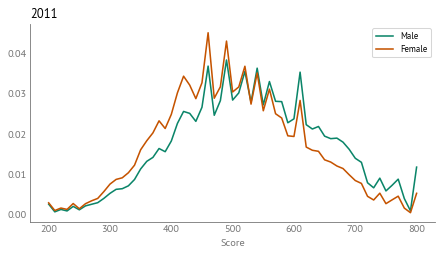

In [38]:
compare_spikes(df_map, 2011)

Male=532.3130225588645, Female=498.5023529425038, Diff=33.81066961636071


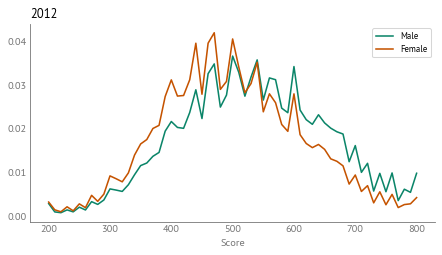

In [39]:
compare_spikes(df_map, 2012)

Male=530.910871391536, Female=499.4024808955207, Diff=31.508390496015352


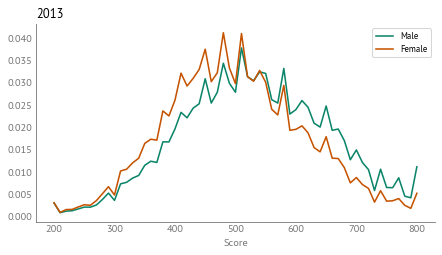

In [40]:
compare_spikes(df_map, 2013)

Male=529.823844710747, Female=498.5317582201221, Diff=31.292086490624968


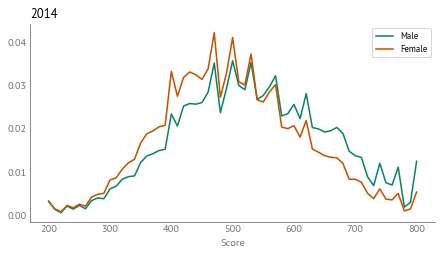

In [41]:
compare_spikes(df_map, 2014)

Male=527.1939174788187, Female=495.92306900706967, Diff=31.27084847174899


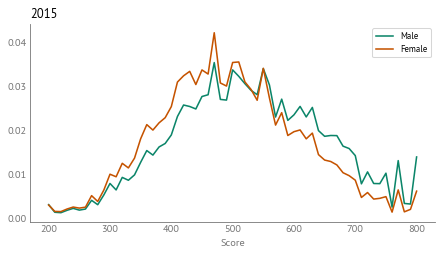

In [42]:
compare_spikes(df_map, 2015)

In [43]:
def plot_selection_function(idata, col, thetas, **options):
    thetas_xr = xr.DataArray(thetas, dims="theta", coords={"theta": thetas})

    # Extract posterior samples of alpha and beta ---
    posterior = idata['posterior']  # shape (chain, draw)

    # Compute logits and apply sigmoid ---
    #logits = posterior["alpha"] + posterior["beta"] * thetas_xr
    logits = posterior["beta"] * thetas_xr
    p = xr.apply_ufunc(expit, logits)

    # Compute median and HDI ---
    median = p.median(dim=["chain", "draw"])
    hdi_bounds = az.hdi(p, hdi_prob=0.94)
    low, high = hdi_bounds['x'].T

    # Plot ---
    plt.plot(thetas, median, **options)
    plt.fill_between(
        thetas,
        low,
        high,
        alpha=0.3,
    )    

## Simple Model

In [86]:
full_thetas = np.arange(100, 910, 10)
full_thetas

array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
       360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
       490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610,
       620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740,
       750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870,
       880, 890, 900])

In [87]:
scale = 400
full_thetas_scaled = (full_thetas - 500) / scale
full_thetas_scaled

array([-1.   , -0.975, -0.95 , -0.925, -0.9  , -0.875, -0.85 , -0.825,
       -0.8  , -0.775, -0.75 , -0.725, -0.7  , -0.675, -0.65 , -0.625,
       -0.6  , -0.575, -0.55 , -0.525, -0.5  , -0.475, -0.45 , -0.425,
       -0.4  , -0.375, -0.35 , -0.325, -0.3  , -0.275, -0.25 , -0.225,
       -0.2  , -0.175, -0.15 , -0.125, -0.1  , -0.075, -0.05 , -0.025,
        0.   ,  0.025,  0.05 ,  0.075,  0.1  ,  0.125,  0.15 ,  0.175,
        0.2  ,  0.225,  0.25 ,  0.275,  0.3  ,  0.325,  0.35 ,  0.375,
        0.4  ,  0.425,  0.45 ,  0.475,  0.5  ,  0.525,  0.55 ,  0.575,
        0.6  ,  0.625,  0.65 ,  0.675,  0.7  ,  0.725,  0.75 ,  0.775,
        0.8  ,  0.825,  0.85 ,  0.875,  0.9  ,  0.925,  0.95 ,  0.975,
        1.   ])

In [88]:
left_mask = full_thetas < 200
right_mask = full_thetas > 800
center_mask = (full_thetas >= 200) & (full_thetas <= 800)

In [89]:
thetas = full_thetas[center_mask]
thetas

array([200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320,
       330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450,
       460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580,
       590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710,
       720, 730, 740, 750, 760, 770, 780, 790, 800])

In [90]:
thetas_centered = thetas - 500

In [91]:
thetas_scaled = thetas_centered / scale

In [92]:
year = 2014
sex = 'Male'
counts_obs = df_map[year].loc[thetas, sex]
counts_obs

Score
200    2659
210    1170
220     552
230    1755
240    1195
       ... 
760    5532
770    8774
780    1556
790    2421
800    9835
Name: Male, Length: 61, dtype: int64

In [93]:
N_obs = int(counts_obs.sum())
N_thetas = len(thetas)
N_full_thetas = len(full_thetas)

# Assuming for now that half of all high school seniors took the test
N_total = N_obs * 2
N_total, N_obs

(1567140, 783570)

{'alpha': np.float64(4.300178987723759), 'beta': np.float64(83.84212820172407)}

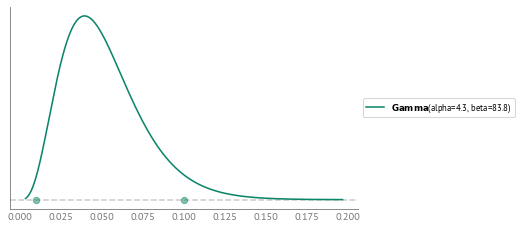

In [94]:
import preliz as pz

dist, plot = pz.maxent(pz.Gamma(), lower=0.01, upper=0.1, mass=0.95)
beta_params = dist.params_dict
beta_params

{'alpha': np.float64(22.785324935720883),
 'beta': np.float64(0.23070884391059038)}

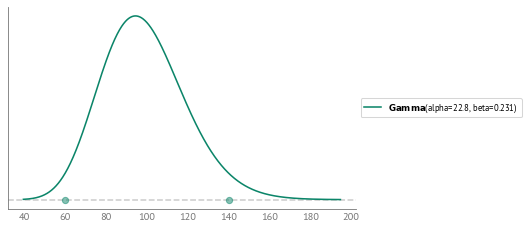

In [95]:
dist, plot = pz.maxent(pz.Gamma(), lower=60, upper=140, mass=0.95)
sigma_params = dist.params_dict
sigma_params

{'alpha': np.float64(49.570464487232954),
 'beta': np.float64(918.0581114134479)}

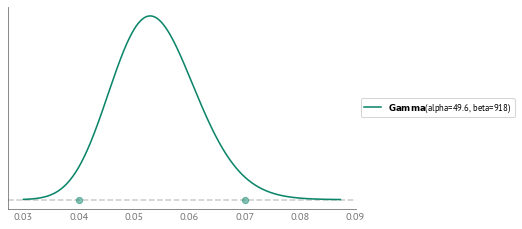

In [162]:
dist, plot = pz.maxent(pz.Gamma(), lower=0.04, upper=0.07, mass=0.95)
sigma_noise_params = dist.params_dict
sigma_noise_params

In [163]:
sigma_noise = 0.05

In [166]:
def make_model(N_obs, counts_obs):
    with pm.Model() as model:
        # Latent population score distribution
        mu = pm.Normal("mu", mu=500, sigma=30)
        sigma = pm.Gamma("sigma", **sigma_params)

        # Selection model: logistic function
        beta = pm.Gamma("beta", **beta_params)
        
        # Compute population distribution (normalized logpdf)
        log_pdf = pm.logp(pm.Normal.dist(mu=mu, sigma=sigma), full_thetas)
        
        # Generate perturbations in the center region
        # sigma_noise = pm.Gamma("sigma_noise", **sigma_noise_params)
        log_noise_raw = pm.ZeroSumNormal("log_noise_raw", sigma=sigma_noise, 
                                         shape=(len(thetas),))

        # --- Detrend log_noise ---
        # slope = (x·y) / (x·x)
        x = thetas_scaled
        slope = pm.math.dot(log_noise_raw, x) / pm.math.dot(x, x)
        log_noise = pm.Deterministic("log_noise", log_noise_raw - slope * x)

        log_noise_full = pt.zeros_like(full_thetas)
        log_noise_full = pt.set_subtensor(log_noise_full[center_mask], log_noise)

        log_selection = beta * full_thetas_scaled
        
        # add up the logits
        logits = log_pdf + log_selection + log_noise_full
        
        # convert logits to probabilities
        pdf = pm.Deterministic("pdf", pm.math.sigmoid(logits))

        # roll up the tails
        left_mass = pdf[left_mask].sum()
        right_mass = pdf[right_mask].sum()
        center_pdf = pdf[center_mask]

        center_pdf = pt.set_subtensor(center_pdf[0], center_pdf[0] + left_mass)
        center_pdf = pt.set_subtensor(center_pdf[-1], center_pdf[-1] + right_mass)

        # normalize
        test_pdf = center_pdf / pm.math.sum(center_pdf)

        # Multinomial likelihood for binned scores
        pm.Multinomial("obs_bins", n=N_obs, p=test_pdf, observed=counts_obs)
        
    return model

In [167]:
model = make_model(N_obs, counts_obs)

with model:
    prior = pm.sample_prior_predictive(1000)
    idata = pm.sample(target_accept=0.95)

Sampling: [beta, log_noise_raw, mu, obs_bins, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, beta, log_noise_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [170]:
#pm.summary(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])
pm.summary(idata, var_names=['mu', 'sigma', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,528.525,1.001,526.701,530.181,0.016,0.017,4409.0,2959.0,1.0
sigma,125.125,0.109,124.927,125.331,0.001,0.002,10247.0,2421.0,1.0
beta,0.052,0.025,0.012,0.099,0.000,0.000,4502.0,3028.0,1.0


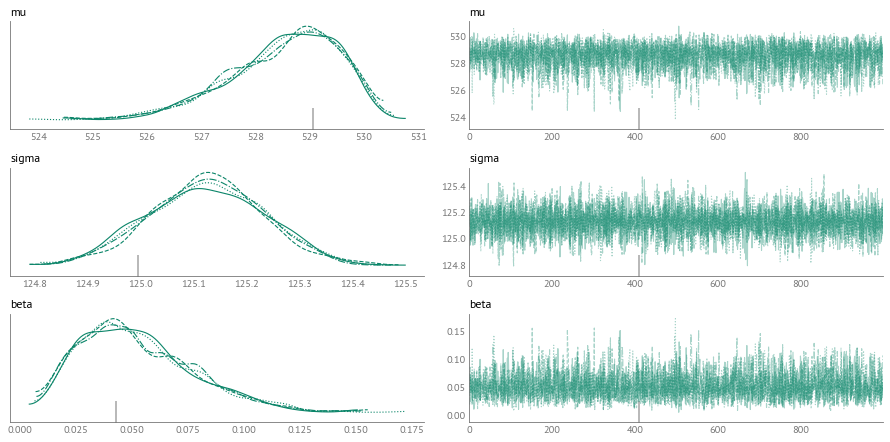

In [171]:
pm.plot_trace(idata, var_names=['mu', 'sigma', 'beta'])
decorate()

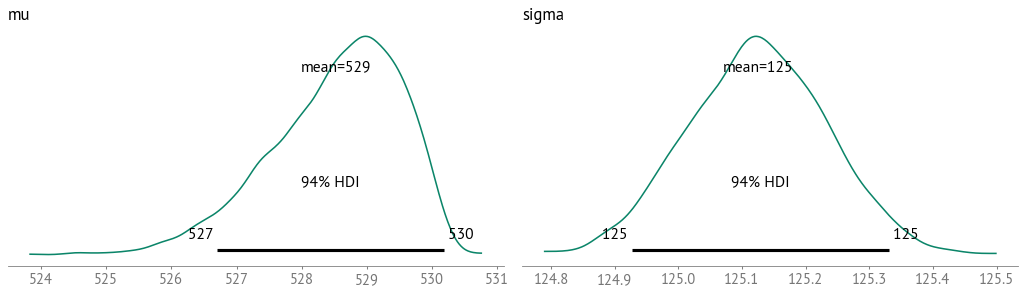

In [172]:
pm.plot_posterior(idata, var_names=['mu', 'sigma'])
decorate()

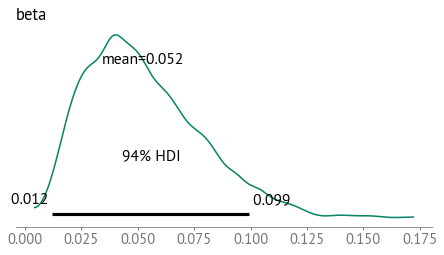

In [173]:
#pm.plot_posterior(idata, var_names=['alpha', 'beta'])

pm.plot_posterior(idata, var_names=['beta'])
decorate()

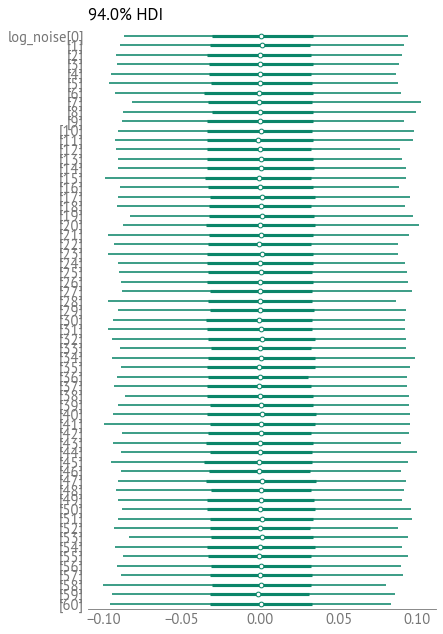

In [174]:
az.plot_forest(idata, var_names='log_noise', combined=True);

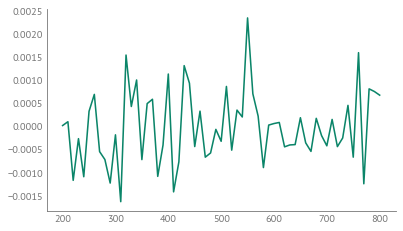

In [159]:
log_noise = np.median(az.extract(idata)['log_noise'], axis=1)
plt.plot(thetas, log_noise);

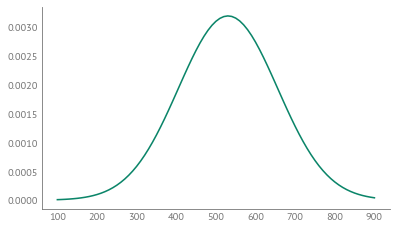

In [160]:
pop_pdf = np.median(az.extract(idata)['pdf'], axis=1)
plt.plot(full_thetas, pop_pdf);

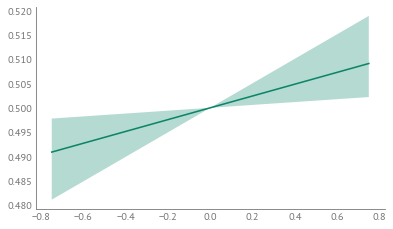

In [161]:
plot_selection_function(idata, 'sat_math', thetas_scaled)

## Parameter recovery

In [220]:
def generate_with_pymc(
    N_total, true_mu, true_sigma, true_alpha, true_beta, true_log_noise, random_seed=123
):
    with pm.Model() as gen:
        # Fixed “true” parameters as constants (no uncertainty)
        mu = pm.Data("mu", true_mu)
        sigma = pm.Data("sigma", true_sigma)
        alpha = pm.Data("alpha", true_alpha)
        beta = pm.Data("beta", true_beta)
        log_noise = pm.Data("log_noise", true_log_noise)
        
        logp_vals = pm.logp(pm.Normal.dist(mu=mu, sigma=sigma), full_thetas)
        perturbed_logp = logp_vals + log_noise - pm.math.mean(log_noise)
        logp_normalizer = pm.math.logsumexp(perturbed_logp)
        pop_pdf = pm.Deterministic("pop_pdf", pm.math.exp(perturbed_logp - logp_normalizer))

        # tails → center
        left_mass  = pop_pdf[left_mask].sum()
        right_mass = pop_pdf[right_mask].sum()
        center_pdf = pop_pdf[center_mask]
        center_pdf = pt.set_subtensor(center_pdf[0],  center_pdf[0]  + left_mass)
        center_pdf = pt.set_subtensor(center_pdf[-1], center_pdf[-1] + right_mass)

        # selection
        logits = alpha + beta * thetas_scaled
        p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

        test_unnorm = center_pdf * p_take
        prob_test = pm.Deterministic("prob_test", test_unnorm.sum())
        test_pdf = pm.Deterministic("test_pdf", test_unnorm / test_unnorm.sum())

        # generative nodes (no observed)
        N_test = pm.Binomial("N_test", n=N_total, p=prob_test)
        obs_bins = pm.Multinomial("obs_bins", n=N_test, p=test_pdf)

        prior_pred = pm.sample_prior_predictive(
            draws=1, 
            var_names=["N_test", "obs_bins", "prob_test", "test_pdf", "p_take"],
            random_seed=random_seed
        )
        return prior_pred

In [239]:
N_total=1_500_000
true_mu=530
true_sigma=120
true_alpha=0.0
true_beta=0.015
true_log_noise = log_noise

prior_pred = generate_with_pymc(
    N_total, true_mu, true_sigma, true_alpha, true_beta, true_log_noise, random_seed=4
)

Sampling: [N_test, obs_bins]


In [240]:
N_test_draw = int(prior_pred.prior["N_test"].values.squeeze())
N_test_draw

755548

In [241]:
counts_draw = np.asarray(prior_pred.prior["obs_bins"].values.squeeze(), dtype=int)
counts_draw

array([ 2274,   670,  1011,   869,  1689,  1170,  1892,  2231,  2374,
        3131,  3981,  4708,  4822,  5164,  6409,  8060,  9467, 10272,
       12007, 11266, 13163, 16659, 18530, 18386, 16878, 19417, 27086,
       18360, 20823, 28902, 21493, 23051, 26873, 21465, 27688, 20997,
       25192, 21981, 21985, 17792, 18721, 27210, 17089, 16782, 16883,
       14950, 14556, 14099, 13509, 12170, 10703,  9976,  5882,  4955,
        6838,  4278,  5482,  6591,  3242,   989, 10455])

531.0491886245221


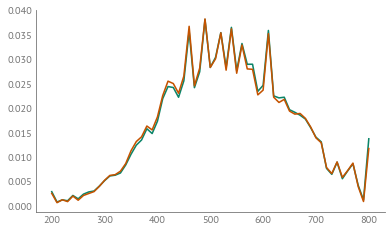

In [242]:
pmf = Pmf(counts_draw, thetas)
pmf.normalize()
pmf.plot(label='draw')

pmf = Pmf(counts_obs, thetas)
pmf.normalize()
pmf.plot(label='observed')

pmf.normalize()
print(pmf.mean())

In [243]:
N_test_draw, N_obs

(755548, 770605)

In [244]:
model = make_model(N_test_draw, counts_draw)
#model = make_model(N_obs, counts_obs)

with model:
    idata = pm.sample(target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, log_noise_raw, alpha, beta]


Output()

/home/downey/miniconda3/envs/SelectionSAT/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


In [245]:
pm.summary(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,532.555,0.543,531.585,533.465,0.015,0.019,1675.0,858.0,1.0
sigma,120.616,0.117,120.401,120.841,0.002,0.002,2972.0,2442.0,1.0
alpha,0.011,0.003,0.006,0.016,0.000,0.000,2100.0,981.0,1.0
beta,0.011,0.007,0.000,0.023,0.000,0.000,1609.0,913.0,1.0


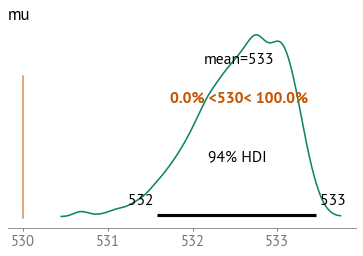

In [246]:
az.plot_posterior(idata, var_names=['mu'], ref_val=true_mu);

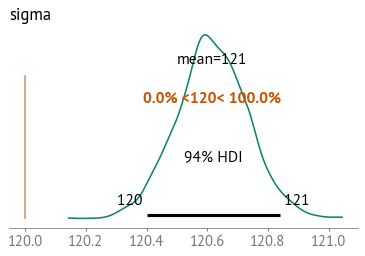

In [247]:
az.plot_posterior(idata, var_names=['sigma'], ref_val=true_sigma);

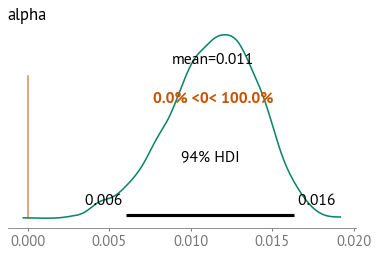

In [248]:
az.plot_posterior(idata, var_names=['alpha'], ref_val=true_alpha);

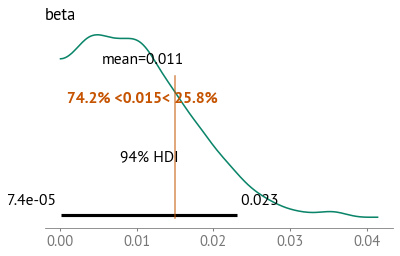

In [249]:
az.plot_posterior(idata, var_names=['beta'], ref_val=true_beta);

## Hierarchical

In [51]:
def get_counts_obs(year, sex):
    return df_map[year].loc[thetas, sex]

In [52]:
years = [2011, 2012, 2013, 2014, 2015]
sexes = ['Male', 'Female']

data = np.array([
    [get_counts_obs(year, sex=sex) for sex in sexes]
    for year in years
])

data.shape  # (n_years, n_sexes, n_scores)

(5, 2, 61)

In [53]:
data.sum(axis=2)

array([[770605, 876518],
       [778142, 886337],
       [776092, 883955],
       [783570, 888825],
       [794802, 903719]])

In [54]:
N_obs = data.sum(axis=2)

# Assuming for now that half of all high school seniors took the test
N_total = N_obs * 2
N_total, N_obs

(array([[1541210, 1753036],
        [1556284, 1772674],
        [1552184, 1767910],
        [1567140, 1777650],
        [1589604, 1807438]]),
 array([[770605, 876518],
        [778142, 886337],
        [776092, 883955],
        [783570, 888825],
        [794802, 903719]]))

In [162]:
import pytensor.tensor as pt 

coords = {
    'year': years,
    'sex': sexes,
    'full_score': full_thetas,  # 81
    'score': thetas_centered,     # 61
}

with pm.Model(coords=coords) as model:
    # Data
    data_pt = pm.Data("data", data, dims=("year", "sex", "score"))
    N_obs_pt = pm.Data("N_obs", N_obs, dims=("year", "sex"))
    N_total_pt = pm.Data("N_total", N_total, dims=("year", "sex"))

    # Latent population score distribution
    mu = pm.Normal("mu", mu=500, sigma=30, dims='sex')
    sigma = pm.Gamma("sigma", alpha=20, beta=0.2, dims='sex')

    # Compute population distribution (normalized logpdf)
    mu_b = mu[:, None]
    sigma_b = sigma[:, None]
    theta_b = full_thetas[None, :]

    logp_vals = pm.logp(pm.Normal.dist(mu=mu_b, sigma=sigma_b), theta_b) # sex, score
    log_noise = pm.ZeroSumNormal("log_noise", sigma=0.05, dims=['year', 'full_score'])
    # TODO: consider taking diffs of log_noise
    
    perturbed_logp = logp_vals[None, :, :] + log_noise[:, None, :]
    logp_normalizer = pm.math.logsumexp(perturbed_logp, axis=-1, keepdims=True)
    pop_pdf = pm.math.exp(perturbed_logp - logp_normalizer)
    
    # collect tail mass per (year, sex)
    left_mass = pop_pdf[:, :, left_mask].sum(axis=-1)   # shape (year, sex)
    right_mass = pop_pdf[:, :, right_mask].sum(axis=-1) # shape (year, sex)

    # slice out the center scores
    center_pdf = pop_pdf[:, :, center_mask]             # shape (year, sex, n_center)

    # add tail mass into the first and last bins
    center_pdf = pt.set_subtensor(center_pdf[:, :, 0],  center_pdf[:, :, 0]  + left_mass)
    center_pdf = pt.set_subtensor(center_pdf[:, :, -1], center_pdf[:, :, -1] + right_mass)

    # Selection model: logistic function
    alpha = pm.Normal("alpha", mu=0, sigma=0.1, dims=['year', 'sex'])
    #beta = pm.Normal("beta", mu=0, sigma=0.01, dims=['year', 'sex'])
    beta = pm.HalfNormal("beta", sigma=0.01, dims=['year', 'sex'])

    logits = alpha[:, :, None] + beta[:, :, None] * thetas_scaled[None, None, :]
    p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

    # Test-taker score distribution
    test_unnorm = center_pdf * p_take
    prob_test = pm.math.sum(test_unnorm, axis=-1)
    test_pdf = test_unnorm / pm.math.sum(test_unnorm, axis=-1, keepdims=True)

    # Binomial likelihood for number of test-takers
    pm.Binomial("N_test", n=N_total_pt, p=prob_test, observed=N_obs_pt)

    # Multinomial likelihood for binned scores
    pm.Multinomial("obs_bins", n=N_obs_pt, p=test_pdf, observed=data_pt,
                  dims=['year', 'sex', 'score'])

    prior = pm.sample_prior_predictive(1000)

Sampling: [N_test, alpha, beta, log_noise, mu, obs_bins, sigma]


In [163]:
with model:
    idata = pm.sample(target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, log_noise, alpha, beta]


Output()

/home/downey/miniconda3/envs/SelectionSAT/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 126 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [164]:
pm.summary(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[Male],521.888,0.855,520.385,523.560,0.037,0.017,545.0,1296.0,1.01
mu[Female],503.080,0.254,502.616,503.559,0.015,0.007,299.0,627.0,1.01
sigma[Male],119.403,0.150,119.133,119.696,0.011,0.004,201.0,746.0,1.01
sigma[Female],112.499,0.107,112.293,112.689,0.008,0.004,159.0,359.0,1.02
"alpha[2011, Male]",-0.034,0.002,-0.037,-0.030,0.000,0.000,2863.0,2773.0,1.00
"alpha[2011, Female]",0.000,0.002,-0.002,0.003,0.000,0.000,3602.0,2542.0,1.00
"alpha[2012, Male]",-0.036,0.002,-0.039,-0.033,0.000,0.000,3236.0,2845.0,1.00
"alpha[2012, Female]",0.000,0.001,-0.003,0.003,0.000,0.000,4325.0,2963.0,1.00
"alpha[2013, Male]",-0.032,0.002,-0.035,-0.029,0.000,0.000,1742.0,2095.0,1.00
"alpha[2013, Female]",0.000,0.002,-0.003,0.003,0.000,0.000,3993.0,3034.0,1.00


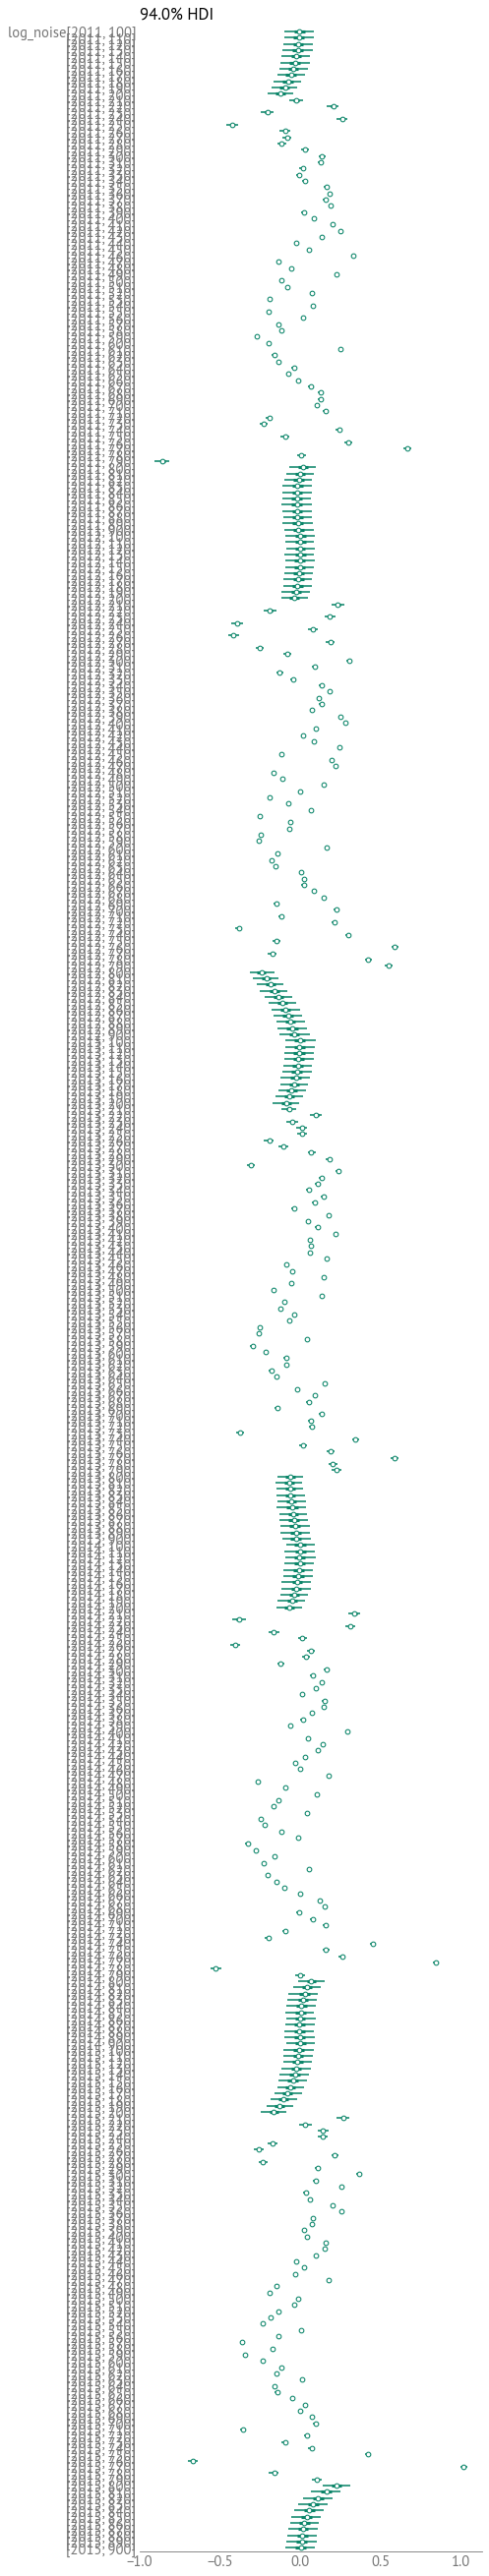

In [165]:
az.plot_forest(idata, var_names='log_noise', combined=True);

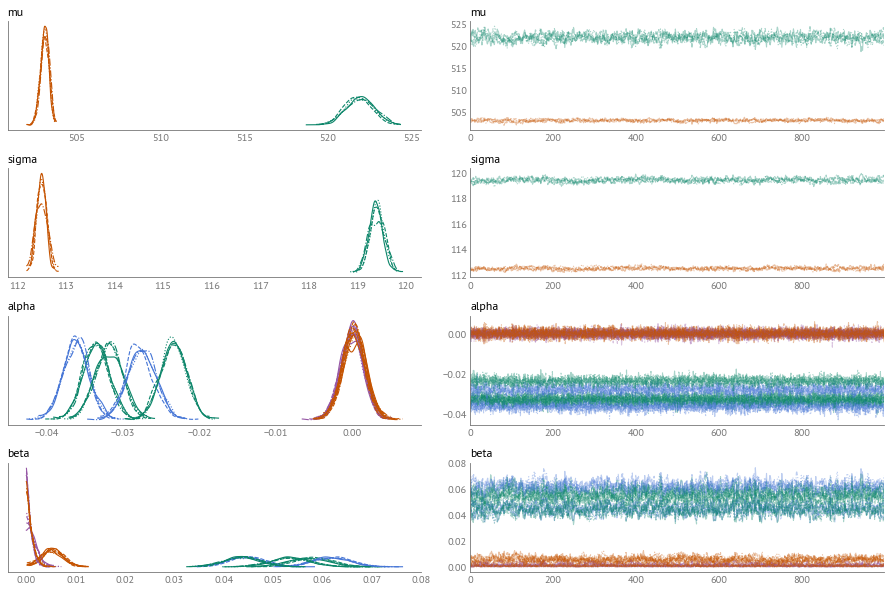

In [166]:
pm.plot_trace(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])
decorate()

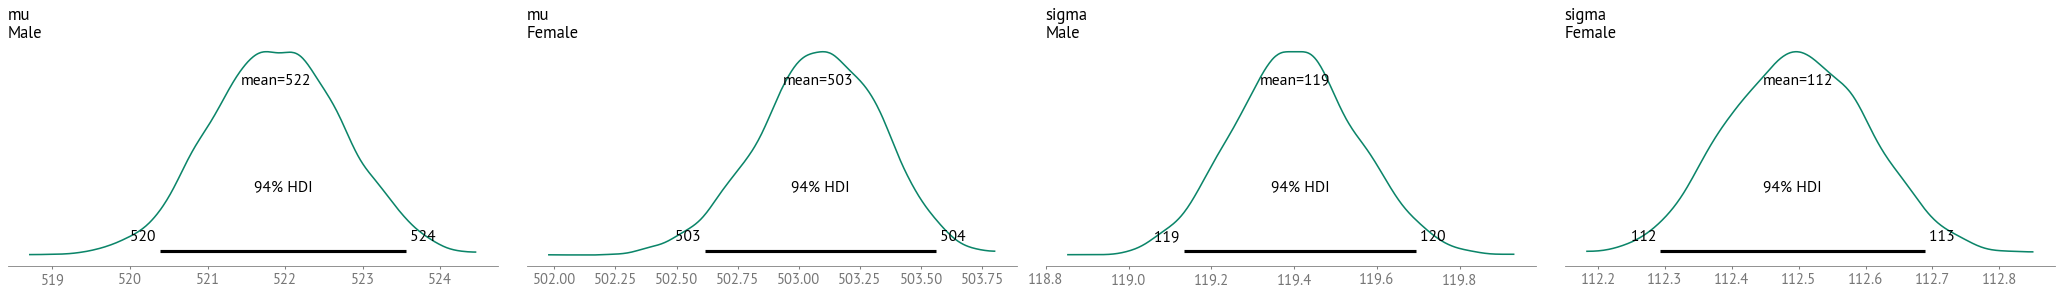

In [167]:
pm.plot_posterior(idata, var_names=['mu', 'sigma'])
decorate()

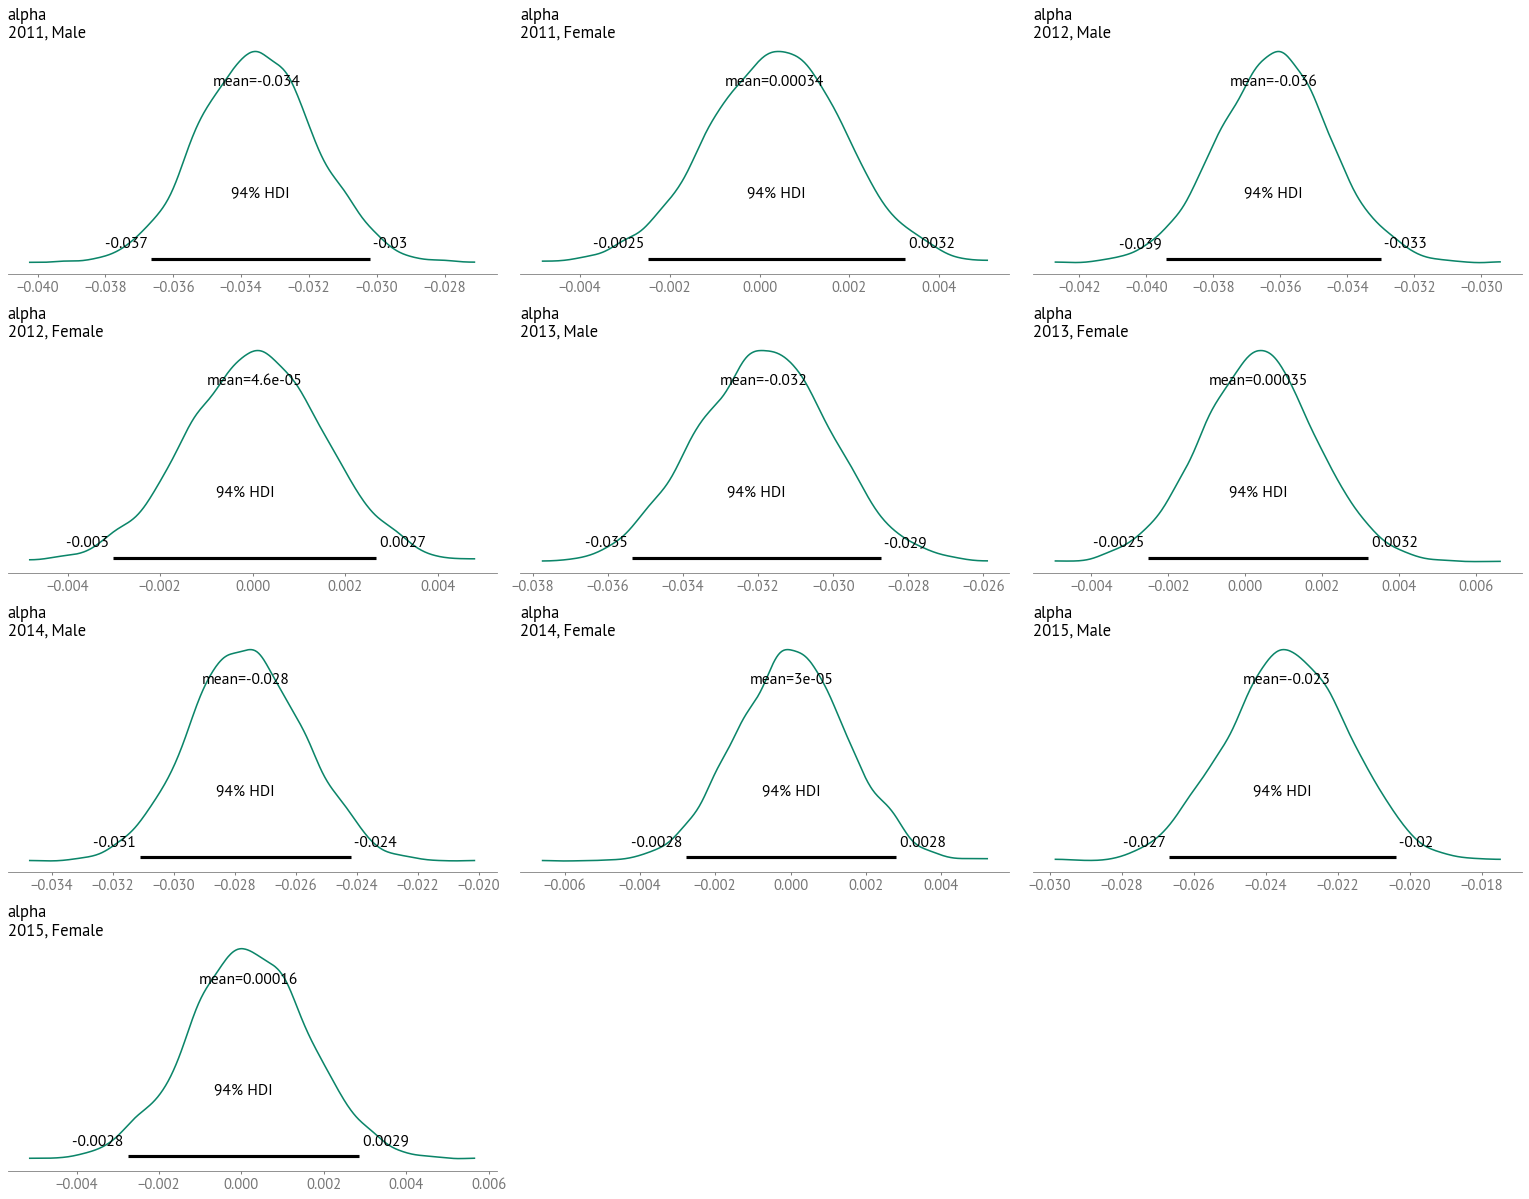

In [168]:
pm.plot_posterior(idata, var_names=['alpha'])
decorate()

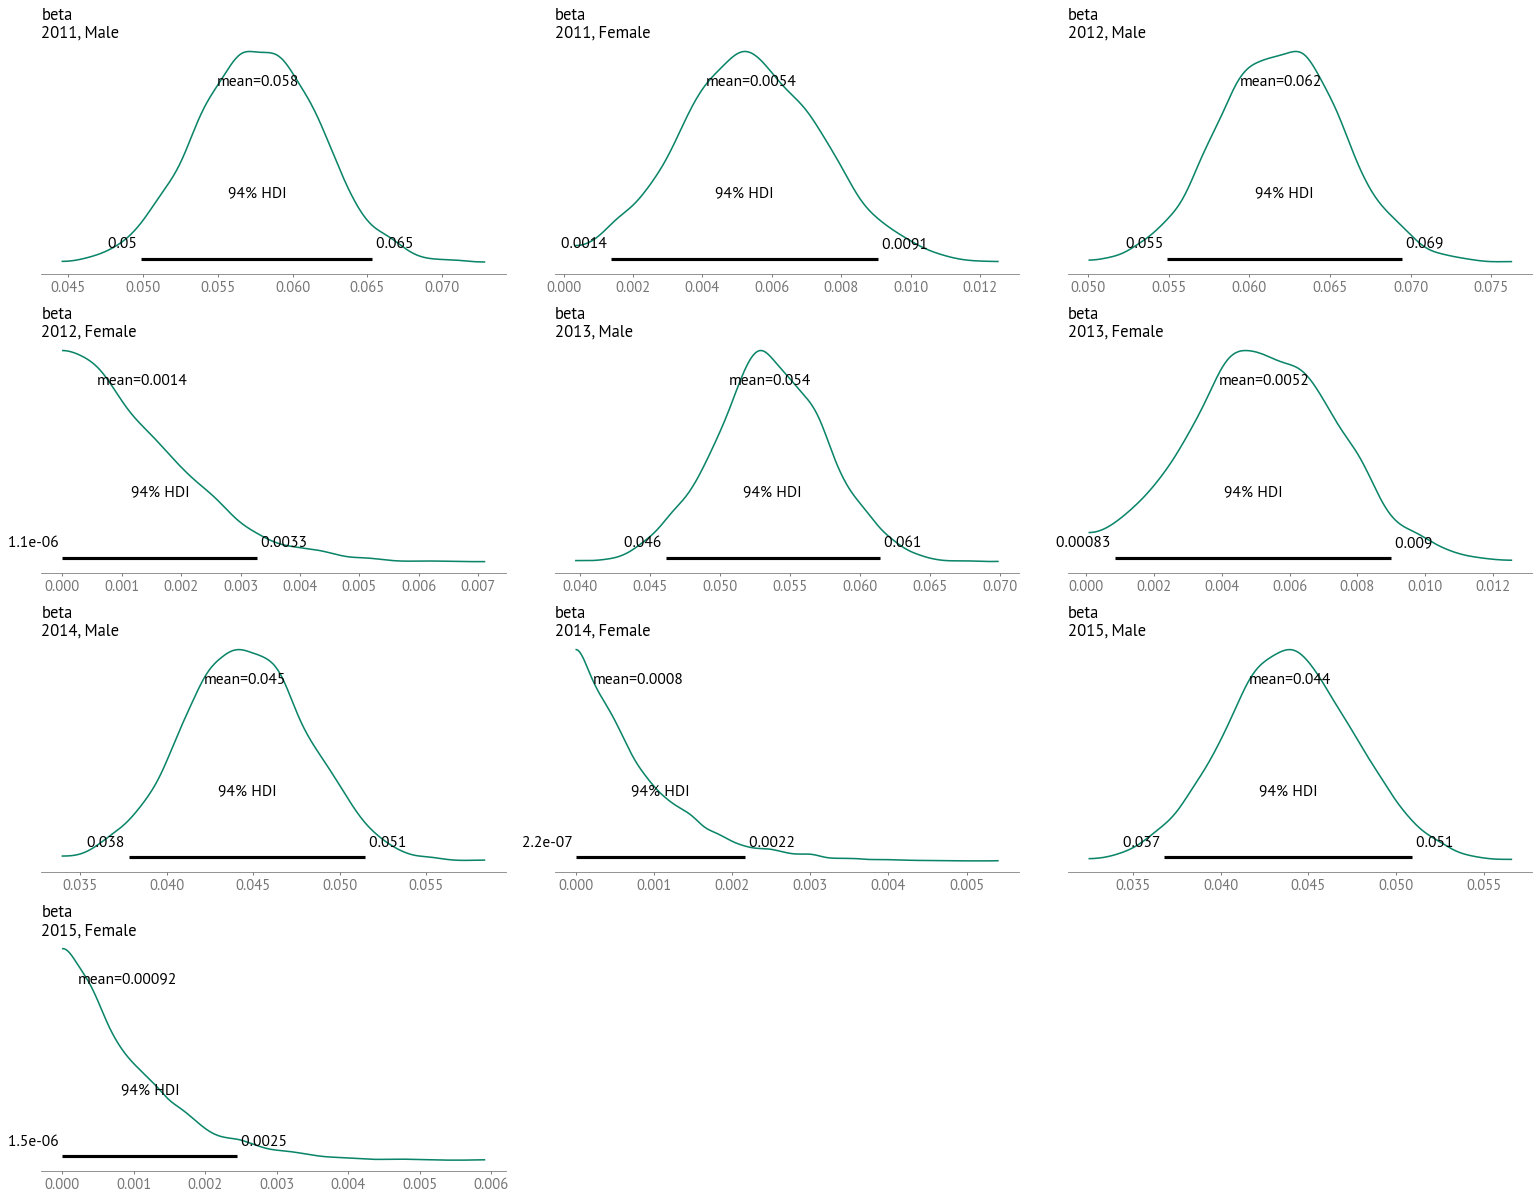

In [169]:
pm.plot_posterior(idata, var_names=['beta'])
decorate()

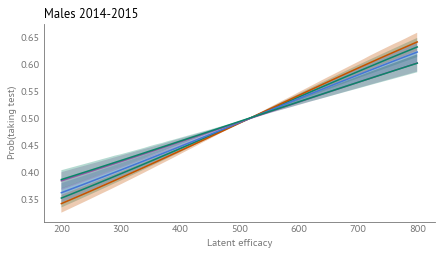

In [170]:
for year in years:
    idata_one = idata.sel(year=year, sex="Male")
    plot_selection_function(idata_one, None, thetas_centered / 30)
    
decorate(xlabel='Latent efficacy', ylabel='Prob(taking test)', title='Males 2014-2015')

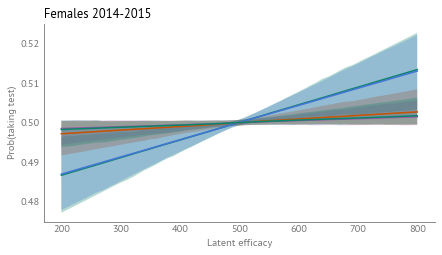

In [171]:
for year in years:
    idata_one = idata.sel(year=year, sex="Female")
    plot_selection_function(idata_one, None, thetas_centered / 30)
    
decorate(xlabel='Latent efficacy', ylabel='Prob(taking test)', title='Females 2014-2015')

In [172]:
with model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [N_test, obs_bins]


Output()

In [173]:
post_pred

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [174]:
obs_bins_post_pred = az.extract(post_pred, group='posterior_predictive')['obs_bins']
obs_bins_post_pred

<xarray.DataArray 'obs_bins' (year: 5, sex: 2, score: 61, sample: 4000)> Size: 20MB
array([[[[ 1820,  1987,  1829, ...,  1985,  1885,  1847],
         [  589,   584,   585, ...,   559,   601,   600],
         [  908,   935,   917, ...,   935,   970,   877],
         ...,
         [ 2969,  3124,  2949, ...,  2919,  3097,  2988],
         [ 1081,  1039,  1114, ...,  1092,  1059,  1163],
         [ 9880, 10003,  9986, ..., 10016,  9849,  9993]],

        [[ 3064,  2913,  3012, ...,  3002,  3065,  3107],
         [  965,  1010,   987, ...,   987,   927,   968],
         [ 1546,  1529,  1606, ...,  1523,  1597,  1476],
         ...,
         [ 1466,  1564,  1445, ...,  1462,  1602,  1532],
         [  533,   518,   479, ...,   545,   495,   539],
         [ 3895,  3992,  3926, ...,  4048,  3989,  4040]]],


       [[[ 1983,  1996,  1956, ...,  1946,  1823,  1990],
         [  766,   742,   739, ...,   683,   717,   748],
         [  621,   627,   610, ...,   627,   620,   614],
...
         [ 1166,  1282,  1245, ...,  1228,  1326,  1203],
         [ 4240,  4281,  4227, ...,  4290,  4355,  4169]]],


       [[[ 2119,  2112,  2251, ...,  2305,  2237,  2187],
         [  966,   922,   918, ...,   936,   964,   971],
         [  928,   922,   906, ...,   936,   944,   865],
         ...,
         [ 2728,  2594,  2631, ...,  2721,  2699,  2691],
         [ 3022,  2969,  2997, ...,  2908,  2891,  2966],
         [11747, 11589, 11377, ..., 11555, 11597, 11896]],

        [[ 3388,  3316,  3397, ...,  3370,  3219,  3430],
         [ 1441,  1414,  1388, ...,  1503,  1374,  1446],
         [ 1432,  1479,  1425, ...,  1516,  1388,  1522],
         ...,
         [ 1280,  1356,  1378, ...,  1363,  1347,  1322],
         [ 1443,  1314,  1406, ...,  1402,  1472,  1415],
         [ 4869,  4731,  4860, ...,  4864,  4876,  5050]]]],
      shape=(5, 2, 61, 4000))
Coordinates:
  * year     (year) int64 40B 2011 2012 2013 2014 2015
  * sex      (sex) <U6 48B 'Male' 'Female'
  * score    (score) int64 488B -300 -290 -280 -270 -260 ... 260 270 280 290 300
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

In [175]:
obs_bins_post_pred.shape

(5, 2, 61, 4000)

In [176]:
medians = np.median(obs_bins_post_pred, axis=-1)
medians.shape

(5, 2, 61)

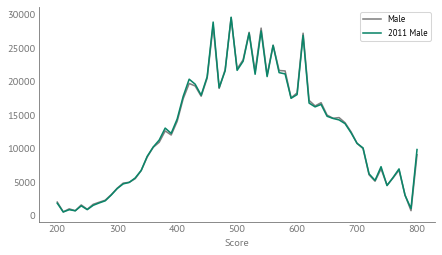

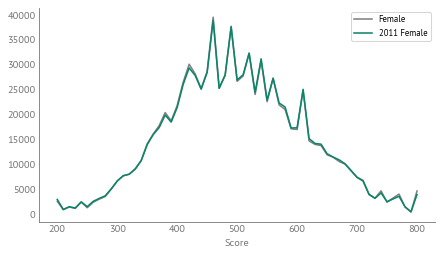

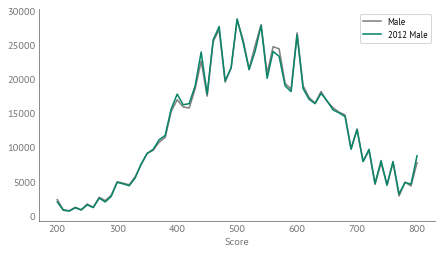

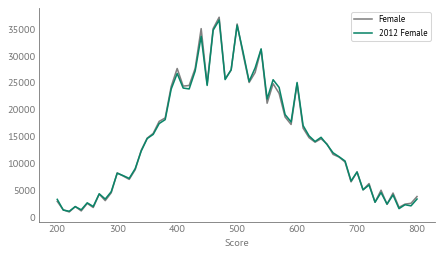

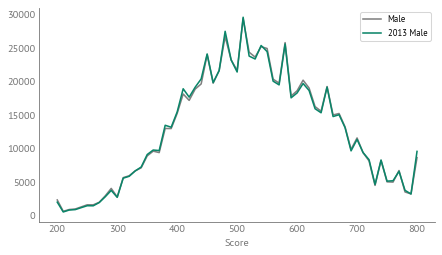

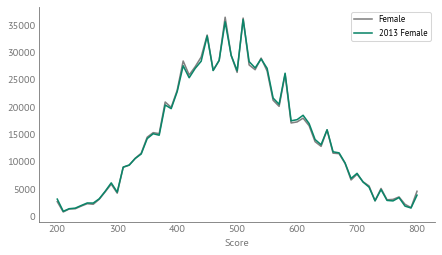

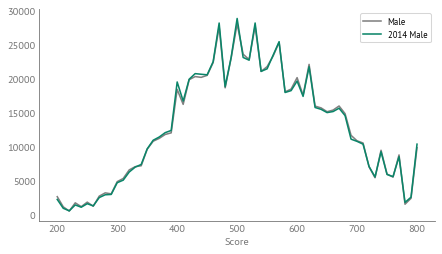

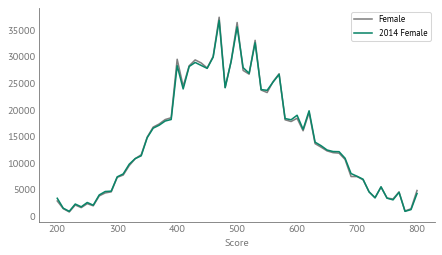

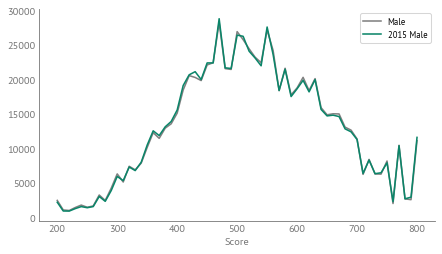

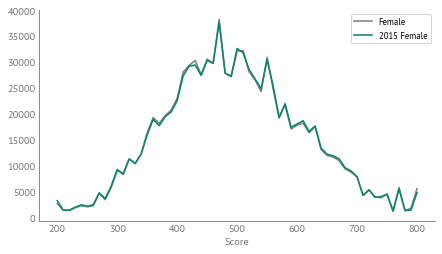

In [178]:
for i, year in enumerate(years):
    for j, sex in enumerate(sexes):
        plt.figure()
        df_map[year][sex].plot(color='gray')
        plt.plot(thetas, medians[i, j], label=f'{year} {sex}')
        decorate()